# Intro

While in the previous experiment / model the participant picked an utterance given a picture, in this model 
- They pick a picture (out of some options) 
- Given 
    - An utterance: One of the 36 possible utterances from the previous experiments.
    - The goal of the speaker who produced the utterance: Can be high/low

There are possible 36 utterances, but some are compatible with only 1 state

`data` should have:

- response: Says whether the participant chose the left or right one of the displayed arrays, encoded respectively as 0 and 1.
- shown_left: what array was shown to the participant on the left (index of state)
- shown_right: what array was shown to the participant on the right (index of state)
- condition: Which of the three argumentative conditions ('high', 'low', 'neutral') the participant was in
- id: id of the participant
- utterance: which utterance was shown to the participant
- index_utterance: the index of the utterance shown to the participant

# Imports

In [9]:
import os
import errno
from importlib import reload
import pickle 
from pprint import pprint
from itertools import product
from glob import glob
from os.path import basename, splitext, split

In [10]:
from numba import jit

In [11]:
import pandas as pd
from scipy import stats
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
# just so saved plots aren't also shown
matplotlib.use('Agg')
%matplotlib inline
import seaborn as sns

import pymc3 as pm
import theano as T
import theano.tensor as tt
import arviz as az
import xarray as xr

In [2]:
from glob import glob
from os.path import basename, splitext, exists, join

In [12]:
from functions.helper_functions import save_trace, load_trace
from functions.data_functions import get_and_clean_data_exp1

In [29]:
from functions.argstrengths import (
    calculate_nonparametric_argstrength, 
    theano_calculate_pragmatic_argstrength, 
    theano_calculate_pragmatic_speaker, 
    calculate_argumentative_strength, 
    calculate_maximin_argstrength
)

from functions.helper_functions import (
    verify, 
    normalize, 
    theano_calculate_pragmatic_speaker,
    get_costs,
    calculate_pragmatic_speaker,
    theano_normalize, 
    theano_softmax
)

In [ ]:
# packages versions
print(
    '\n'.join(
        f'{m.__name__}=={m.__version__}' 
        for m in globals().values() 
        if getattr(m, '__version__', None)
    )
)

In [22]:
# This is the location of the traces in Fausto's system
# but they are too large for github.
folder_pilot_traces = '../../arglang_model_fitting/pilot_models_traces/'
# location of raw data in Fausto's system
# but if you've cloned the repo you can just run
# the cell below to load the cleaned data directly
folder_pilot_data = '../../arglang_exp/data_pilot/data_raw.csv'
folder_pilot_cleaned_data = '../data/data_pilot/'

In [27]:
if exists(folder_pilot_data):
    pilot_data = get_and_clean_data_exp1(pathdata=folder_pilot_data)
    raw_data, data, possible_observations, possible_utterances = pilot_data
    data.to_csv(join(folder_pilot_cleaned_data, 'cleaned_data.csv'), index=False)
    pd.DataFrame(possible_observations).to_csv(join(folder_pilot_cleaned_data, 'obs.csv'), index=False)
    pd.DataFrame(possible_utterances).to_csv(join(folder_pilot_cleaned_data, 'utts.csv'), index=False)
else:
    # read the pre-cleaned data
    data = pd.read_csv(join(folder_pilot_cleaned_data, 'cleaned_data.csv'))
    possible_observations = pd.read_csv(join(folder_pilot_cleaned_data, 'obs.csv')).to_numpy()
    possible_utterances = pd.read_csv(join(folder_pilot_cleaned_data, 'utts.csv')).to_numpy()

a total of 200 of the raw datapoints are test trials. This leaves 20 potential datapoints per participant.
8  were excluded because incompletely recorded
4  of the participants were excluded as they gave more than 4 false responses
52  of the observations in the included participants were excluded because literally false


/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/analysis/functions/data_functions.py:83: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  str(len(data[raw_data['trial_name'] != 'main_trials'])) +
/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/analysis/functions/data_functions.py:88: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'condition'] = (data.condition == 'high').astype(int)


# Old code (optimal Bayesian design etc.)

## Calculate all possible trials

In [32]:
from itertools import combinations

In [33]:
shown_left, shown_right, utterances, index_utterance, condition = [], [], [], [], []

# high and low conditions
for cond in [0,1]:
    # for each possible utterance
    for i, utt_comp in enumerate(utterance_observation_compatibility):

        # indices of states compatible with the utterance
        possible_array_indices = np.argwhere(utt_comp).flatten()

        # check that this utterance has at least
        # two compatible states
        if len(possible_array_indices) > 2:

            # find all combinations of two of the compatible states
            for left, right in combinations(possible_array_indices,2):
                shown_left.append(left)
                shown_right.append(right)
                utterances.append(possible_utterances[i])
                index_utterance.append(i)
                condition.append(cond)

In [34]:
# response gets sampled by the prior predictive
utterances = np.apply_along_axis(
    lambda x: '|'.join(x),
    1,
    utterances,
)
index_utterance = np.array(
    index_utterance
)
possible_trials = pd.DataFrame({
    'left': shown_left,
    'right': shown_right,
    'utterance': utterances,
    'index_utterance': index_utterance,
    'condition': condition
})

In [35]:
possible_trials

,left,right,utterance,index_utterance,condition
0,0,2,none|none|right,0,0
1,0,5,none|none|right,0,0
2,0,7,none|none|right,0,0
3,0,8,none|none|right,0,0
4,0,11,none|none|right,0,0
...,...,...,...,...,...
2815,9,14,all|most|wrong,29,1
2816,9,17,all|most|wrong,29,1
2817,13,14,all|most|wrong,29,1
2818,13,17,all|most|wrong,29,1


There are 2820 possible trials, but they are not equally informative: some of them are much better at distinguishing between the different models we have.

In [36]:
# number of possible trials using each utterance
pd.DataFrame(np.unique(
    possible_trials.utterance, 
    return_counts=True
)).T.sort_values(by=1)

,0,1
0,all|most|right,12
1,all|most|wrong,12
4,most|all|right,12
5,most|all|wrong,12
8,most|none|right,12
9,most|none|wrong,12
15,none|most|wrong,12
14,none|most|right,12
23,some|none|wrong,90
22,some|none|right,90


In [37]:
# assign each trial to a participant at random
# 10 trials per participant
possible_trials.loc[:,'id'] = list(map(
    lambda x: x//10,
    np.arange(len(possible_trials))
))

In [38]:
possible_trials.head()

,left,right,utterance,index_utterance,condition,id
0,0,2,none|none|right,0,0,0
1,0,5,none|none|right,0,0,0
2,0,7,none|none|right,0,0,0
3,0,8,none|none|right,0,0,0
4,0,11,none|none|right,0,0,0


## Define pooled models w/ possible trials as ind var

Now, the big question is which trial to ask participants. 
- One approach is to use completely random trials
- Another approach is to find trials that are close to _optimal_, i.e. high expected infogain from them

Let's run the two approaches!

In [41]:
model_base = factory_model_base(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

model_lr_argstrength = factory_model_lr_argstrength(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

model_maximin_argstrength = factory_model_maximin_argstrength(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

model_prag_argstrength = factory_model_prag_argstrength(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

model_nonparametric_argstrength = factory_model_nonparametric_argstrength(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

Defining non-hierarchical model
 __str__ = [   2 2820]
Defining non-hierarchical model
Defining non-hierarchical model


/tmp/ipykernel_20341/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


In [244]:
models = {
    'base': model_base,
    'lr_argstrength': model_lr_argstrength,
    'maximin_argstrength': model_maximin_argstrength,
    'prag_argstrength': model_prag_argstrength,
    'nonparametric_argstrength': model_nonparametric_argstrength
}

In [457]:
model_factories = {
    'base': factory_model_base,
    'lr_argstrength': factory_model_lr_argstrength,
    'maximin_argstrength': factory_model_maximin_argstrength,
    'prag_argstrength': factory_model_prag_argstrength,
    'nonparametric_argstrength': factory_model_nonparametric_argstrength
}

## Models

### Base RSA

In [16]:
def factory_model_base(data, possible_observations, possible_utterances, include_observed=True):
    
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )
                               
    mask_none = np.any(
        possible_utterances=='none', 
        axis=1
    ).astype(int)
    
    with pm.Model() as model_base:
        
        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        p_utterance_given_observation = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
        )
        
        # normalize so each row (signal) is a prob vector
        # to get listener-side probabilities
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            axis=1
        )
        
        # shape (2, trials)
        # for each datapoint, the prob of picking 
        # left and right exam results given the observed utterance
        unnorm_p_selection = p_observation_given_utterance[
            # shown utterance
            data.index_utterance,
            # probabilities of left and right options
            [data.left, data.right]
        ]
        tt.printing.Print()(unnorm_p_selection.shape)
                
        # normalize to find probability of choosing
        # left or right image
        p_selection = theano_normalize(
            unnorm_p_selection,
            0
        )
        
        choices = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
    
    return model_base

In [17]:
def factory_model_base_hierarchical(
        data, possible_observations, 
        possible_utterances, 
        include_observed=True):
    
    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )

    mask_none = np.any(
        possible_utterances=='none', 
        axis=1
    ).astype(int)

    with pm.Model() as model_base_hierarchical:

        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=1,
        )

        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1,
        )

        # sample one deviation from the population-level
        # for each participant
        alpha_zs = pm.Normal(
            'alpha_zs',
            shape=(data.id.max()+1,),
            # NOTE: Reduced to avoid overflow
            sigma=0.1
        )

        alpha = pm.Deterministic(
            'alpha',
            pm.math.exp(
                alpha_mu + 
                alpha_sigma * alpha_zs
            )
        )

        cost = pm.Exponential(
            'costnone',
            lam=1
        )

        costs = mask_none * cost

        # dimensions (participant, utterance, observation)
        p_utterance_given_observation = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
        )

        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            # normalize each utterance across observations
            -1
        )

        # shape (2, # trials)
        # for each datapoint, the prob of picking 
        # left and right exam results given the observed utterance
        unnorm_p_selection = p_observation_given_utterance[
            data.id,
            # shown utterance
            data.index_utterance,
            # probabilities of left and right options
            [data.left, data.right]
        ]

        # normalize to find probability of choosing
        # left or right image
        p_selection = theano_normalize(
            unnorm_p_selection,
            0
        )

        tt.printing.Print()(tt.stack([p_selection.min(), p_selection.max()]))

        choices = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )

        return model_base_hierarchical

### Log-likelihood ratio argstrength RSA

In [18]:
def factory_model_lr_argstrength(data, possible_observations, possible_utterances, 
                                 include_observed=True):
    
    argumentative_strengths_positive = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15,
    )
    argumentative_strengths_negative = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15,
        gamma_disprove=0.85,
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(utterance_observation_compatibility,1)
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_lr_argstrength:

        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))
        
        # normalize so each row (signal) is a prob vector
        # to get listener-side probabilities
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            axis=-1
        )
        
        # shape (2, trial)
        # for each datapoint, the prob of picking 
        # left option given the observed utterance
        p_selection_unnorm = p_observation_given_utterance[
            data.condition,
            data.index_utterance,
            [data.left, data.right]
        ]
        p_selection = theano_normalize(
            p_selection_unnorm,
            0
        )
        
        utterances = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
    
    return model_lr_argstrength

In [19]:
def factory_model_lr_argstrength_hierarchical(data, possible_observations, 
                                              possible_utterances, include_observed=True):
    
    argumentative_strengths_positive = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15,
    )
    argumentative_strengths_negative = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15,
        gamma_disprove=0.85,
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )

    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    with pm.Model() as model_lr_argstrength_hierarchical:

        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=0.5,
        )
        
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1.
        )
        
        # sample one deviation from the population-level
        # for each participant
        alpha_zs = pm.Normal(
            'alpha_zs',
            shape=(data.id.max()+1,),
            # NOTE: Reduced to avoid overflow
            sigma=0.1
        )
        
        alpha = pm.Deterministic(
            'alpha',
            pm.math.exp(
                alpha_mu + 
                alpha_sigma * alpha_zs
            )
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 

        # condition_confusion_participant has length (# participants)
        # and contains the confusion probabilities particpant-wise
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            pm.math.invlogit(beta_mu + beta_offset * beta_sigma)
        )

        cost = pm.Exponential(
            'costnone',
            lam=1
        )
        
        costs = mask_none * cost

        # dims (participant, utterances, observations)
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )
        
        # dims (participant, utterances, observations)
        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )
        
        # dims (condition, participant, utterance, observation)
        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))
        
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            # normalize each utterance across observations
            -1
        )
        
        # shape (2, trials)
        # for each datapoint, the prob of picking 
        # left and right exam results given the observed utterance
        unnorm_p_selection = p_observation_given_utterance[
            data.condition,
            data.id,
            # shown utterance
            data.index_utterance,
            # probabilities of left and right options
            [data.left, data.right]
        ]
        
        # normalize to find probability of choosing
        # left or right image
        p_selection = theano_normalize(
            unnorm_p_selection,
            0
        )
        
        choices = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
            
    return model_lr_argstrength_hierarchical

### Maximin argstrength RSA

In [20]:
def factory_model_maximin_argstrength(data, possible_observations, 
                                      possible_utterances, include_observed=True):
    
    maximin_argstrengths_positive = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15
    )
    maximin_argstrengths_negative = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15,
        gamma_disprove=0.85
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(utterance_observation_compatibility,1)
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_maximin_argstrength:

        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost
        
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            maximin_argstrengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            maximin_argstrengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        # normalize so each row (signal) is a prob vector
        # to get listener-side probabilities
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            axis=-1
        )
                
        # shape (2, trial)
        # for each datapoint, the prob of picking 
        # left option given the observed utterance
        p_selection_unnorm = p_observation_given_utterance[
            data.condition,
            data.index_utterance,
            [data.left, data.right]
        ]
        
        p_selection = theano_normalize(
            p_selection_unnorm,
            0
        )
                
        utterances = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
    
    return model_maximin_argstrength

In [21]:
def factory_model_maximin_argstrength_hierarchical(data, possible_observations, 
                                                   possible_utterances, include_observed=True):
    
    argumentative_strengths_positive = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15
    )
    
    argumentative_strengths_negative = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.15, 
        gamma_disprove=0.85
    )

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )
    
    mask_none = np.any(
        possible_utterances=='none',
        axis=1
    ).astype(int)

    with pm.Model() as model_maximin_argstrength_hierarchical:
        
        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None
        
        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=0.5,
        )
        
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1
        )
        
        # sample one deviation from the population-level
        # for each participant
        alpha_zs = pm.Normal(
            'alpha_zs',
            shape=(data.id.max()+1,),
            sigma=0.1
        )
        
        alpha = pm.Deterministic(
            'alpha',
            pm.math.exp(
                alpha_mu + 
                alpha_sigma * alpha_zs
            )
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 

        # condition_confusion_participant has length (# participants)
        # and contains the confusion probabilities particpant-wise
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            pm.math.invlogit(
                beta_mu + 
                beta_offset * beta_sigma
            )
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        # dims (participant, utterances, observations)
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )
        
        # dims (participant, utterances, observations)
        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )
        
        # dims (condition, participant, utterance, observation)
        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))
        
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            # normalize each utterance across observations
            -1
        )
        
        # shape (2, trials)
        # for each datapoint, the prob of picking 
        # left and right exam results given the observed utterance
        unnorm_p_selection = p_observation_given_utterance[
            data.condition,
            data.id,
            # shown utterance
            data.index_utterance,
            # probabilities of left and right options
            [data.left, data.right]
        ]
        
        # normalize to find probability of choosing
        # left or right image
        p_selection = theano_normalize(
            unnorm_p_selection,
            0
        )
        
        choices = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
            
    return model_maximin_argstrength_hierarchical

### $S_1$ argstrength RSA

In [22]:
def factory_model_prag_argstrength(data, possible_observations, 
                                   possible_utterances, include_observed=True):

    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )

    with pm.Model() as model_prag_argstrength:

        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        prag_argstrengths_positive = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.85, 
            gamma_disprove=0.15,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )

        prag_argstrengths_negative = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.15, 
            gamma_disprove=0.85,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )

        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        # normalize so each row (signal) is a prob vector
        # to get listener-side probabilities
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            axis=-1
        )
        
        # shape (2, trial)
        # for each datapoint, the prob of picking 
        # left option given the observed utterance
        p_selection_unnorm = p_observation_given_utterance[
            data.condition,
            data.index_utterance,
            [data.left, data.right]
        ]
        p_selection = theano_normalize(
            p_selection_unnorm,
            0
        )
        
        utterances = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
    
    return model_prag_argstrength

In [23]:
def factory_model_prag_argstrength_hierarchical(data, possible_observations, 
                                   possible_utterances, include_observed=True):

    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )

    with pm.Model() as model_prag_argstrength_hierarchical:
        
        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=0.5,
        )
        
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1
        )
        
        # sample one deviation from the population-level
        # for each participant
        alpha_zs = pm.Normal(
            'alpha_zs',
            shape=(data.id.max()+1,),
            sigma=0.1
        )
        
        alpha = pm.Deterministic(
            'alpha',
            pm.math.exp(
                alpha_mu + 
                alpha_sigma * alpha_zs
            )
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 

        # condition_confusion_participant has length (# participants)
        # and contains the confusion probabilities particpant-wise
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            pm.math.invlogit(
                beta_mu + 
                beta_offset * beta_sigma
            )
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        prag_argstrengths_positive = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.85, 
            gamma_disprove=0.15,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )

        prag_argstrengths_negative = theano_calculate_pragmatic_argstrength(
            possible_utterances, 
            possible_observations,
            gamma_prove=0.15, 
            gamma_disprove=0.85,
            alpha=alpha,
            costs=costs,
            p_observation_given_utterance=p_observation_given_utterance
        )
                
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            prag_argstrengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))
        
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            # normalize each utterance across observations
            -1
        )
        
        # shape (2, trials)
        # for each datapoint, the prob of picking 
        # left and right exam results given the observed utterance
        unnorm_p_selection = p_observation_given_utterance[
            data.condition,
            data.id,
            # shown utterance
            data.index_utterance,
            # probabilities of left and right options
            [data.left, data.right]
        ]
        
        # normalize to find probability of choosing
        # left or right image
        p_selection = theano_normalize(
            unnorm_p_selection,
            0
        )
        
        choices = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
    
    return model_prag_argstrength_hierarchical

### Nonparametric argstrength RSA

In [24]:
def factory_model_nonparametric_argstrength(data, possible_observations, possible_utterances, 
                                            include_observed=True):
    
    argumentative_strengths_positive = calculate_nonparametric_argstrength(
        possible_utterances, 
        possible_observations, 
        condition='high'
    ).flatten()
    argumentative_strengths_negative = 1-argumentative_strengths_positive

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )
                               
    mask_none = np.any(possible_utterances=='none', axis=1).astype(int)
    
    with pm.Model() as model_nonparametric_argstrength:
        
        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None

        alpha = pm.Uniform(
            'alpha',
            lower=0,
            upper=5
        )

        beta = pm.Uniform(
            'beta',
            lower=0,
            upper=1
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )

        costs = mask_none * cost

        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )

        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )

        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))

        # normalize so each row (signal) is a prob vector
        # to get listener-side probabilities
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            axis=-1
        )
        
        # shape (2, trial)
        # for each datapoint, the prob of picking 
        # left option given the observed utterance
        p_selection_unnorm = p_observation_given_utterance[
            data.condition,
            data.index_utterance,
            [data.left, data.right]
        ]
        p_selection = theano_normalize(
            p_selection_unnorm,
            0
        )
        
        utterances = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
    
    return model_nonparametric_argstrength

In [25]:
def factory_model_nonparametric_argstrength_hierarchical(data, possible_observations, 
                                                         possible_utterances, include_observed=True):
    
    argumentative_strengths_positive = calculate_nonparametric_argstrength(
        possible_utterances, 
        possible_observations, 
        condition='high'
    ).flatten()
    
    argumentative_strengths_negative = 1-argumentative_strengths_positive

    utterance_observation_compatibility = np.stack([
        verify(*a, possible_observations)
        for a in possible_utterances
    ])

    # literal listener
    p_observation_given_utterance = normalize(
        utterance_observation_compatibility,
        1
    )

    mask_none = np.any(
        possible_utterances=='none', 
        axis=1
    ).astype(int)

    with pm.Model() as model_nonparametric_argstrength_hierarchical:

        if include_observed:
            data_response = pm.Data(
                'observed', 
                data.response
            )
        else:
            data_response = None
        
        alpha_mu = pm.Normal(
            'alpha_mu', 
            mu=0,
            sigma=1,
        )
        
        alpha_sigma = pm.HalfNormal(
            'alpha_sigma',
            sigma=1
        )
        
        # sample one deviation from the population-level
        # for each participant
        alpha_zs = pm.Normal(
            'alpha_zs',
            shape=(data.id.max()+1,),
            sigma=0.1
        )
        
        alpha = pm.Deterministic(
            'alpha',
            pm.math.exp(
                alpha_mu + 
                alpha_sigma * alpha_zs
            )
        )

        # sample the hyperparameters
        # for the beta parameter
        beta_mu = pm.Normal(
            'beta_mu', 
            mu=0,
            sigma=1
        )
        beta_sigma = pm.HalfNormal(
            'beta_sigma',
            sigma=1
        ) 

        # condition_confusion_participant has length (# participants)
        # and contains the confusion probabilities particpant-wise
        beta_offset = pm.Normal(
            'beta_offset',
            # number of participants
            shape=(data.id.max()+1,)
        )
        beta = pm.Deterministic(
            'beta',
            pm.math.invlogit(beta_mu + beta_offset * beta_sigma)
        )

        cost = pm.Exponential(
            'costnone',
            lam=0.5
        )
        
        costs = mask_none * cost

        # dims (participant, utterances, observations)
        p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_positive
        )
        
        # dims (participant, utterances, observations)
        p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
            p_observation_given_utterance, 
            costs,
            alpha, 
            beta,
            argumentative_strengths_negative
        )
        
        # dims (condition, participant, utterance, observation)
        p_utterance_given_observation = tt.stack((
            p_utterance_given_observation_low,
            p_utterance_given_observation_high
        ))
        
        p_observation_given_utterance = theano_normalize(
            p_utterance_given_observation,
            # normalize each utterance across observations
            -1
        )

        # shape (2, trials)
        # for each datapoint, the prob of picking 
        # left and right exam results given the observed utterance
        unnorm_p_selection = p_observation_given_utterance[
            data.condition,
            data.id,
            # shown utterance
            data.index_utterance,
            # probabilities of left and right options
            [data.left, data.right]
        ]
        
        # normalize to find probability of choosing
        # left or right image
        p_selection = theano_normalize(
            unnorm_p_selection,
            0
        )
        
        choices = pm.Categorical(
            'selection',
            p_selection.T,
            observed=data_response,
            shape=len(data)
        )
            
    return model_nonparametric_argstrength_hierarchical

## Prior predictive checks

### Pooled models

**Prior predictive check on all possible trials for each (pooled) model**

In this section, we calculate the prior predictive checks on _all possible trials_, for each of the non-hierarchical models.

In [26]:
# At the bottom of this section, there's a cell to save the 
# prior samples in a file. If the file is there, you can
# load the dictionary since they're annoying to calculate.
with open("./prior_predictive_listenerside.pickle", "rb") as openfile:
    df_prior_answers_right_p = pd.read_pickle(openfile)

Get prior predictive checks for each model:

In [31]:
with model_base:
    sampled_choices_base = pm.sample_prior_predictive(samples=1000)

Defining non-hierarchical model


In [32]:
with model_lr_argstrength:
    sampled_choices_lr_argstrength = pm.sample_prior_predictive(samples=1000)

Defining non-hierarchical model
Defining non-hierarchical model


In [33]:
with model_maximin_argstrength:
    sampled_choices_maximin_argstrength = pm.sample_prior_predictive(samples=1000)

/tmp/ipykernel_13824/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Defining non-hierarchical model
Defining non-hierarchical model


In [34]:
with model_prag_argstrength:
    sampled_choices_prag_argstrength = pm.sample_prior_predictive(samples=1000)

Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


In [35]:
with model_nonparametric_argstrength:
    sampled_choices_nonparametric_argstrength = pm.sample_prior_predictive(samples=1000)

Defining non-hierarchical model
Defining non-hierarchical model


In [ ]:
# for each model, the probability of answering with 
# the image presented on the right for each possible trial
prior_answer_right_p_dict = {
    'base': sampled_choices_base['selection'].mean(0),
    'lr_argstrength': sampled_choices_lr_argstrength['selection'].mean(0),
    'maximin_argstrength': sampled_choices_maximin_argstrength['selection'].mean(0),
    'prag_argstrength': sampled_choices_prag_argstrength['selection'].mean(0),
    'nonparametric_argstrength': sampled_choices_nonparametric_argstrength['selection'].mean(0)
}

# dims: (possible trial, model)
df_prior_answers_right_p = pd.DataFrame(prior_answer_right_p_dict)

In [441]:
df_prior_answers_right_p

,base,lr_argstrength,maximin_argstrength,prag_argstrength,nonparametric_argstrength
0,0.088,0.972,0.971,0.966,0.932
1,0.210,0.962,0.986,0.958,0.939
2,0.440,0.955,0.975,0.929,0.826
3,0.240,0.961,0.976,0.946,0.826
4,0.263,0.957,0.977,0.946,0.926
...,...,...,...,...,...
2815,0.497,0.278,0.031,0.303,0.070
2816,0.348,0.612,0.933,0.564,0.845
2817,0.875,0.177,0.051,0.207,0.073
2818,0.844,0.394,0.144,0.449,0.195


In [40]:
# save the dictionary since it's annoying to calculate
with open("./prior_predictive_listenerside.pickle", "wb") as openfile:
    pd.to_pickle(
        df_prior_answers_right_p,
        openfile
    )

Not plot prior predictive checks

Model base test:

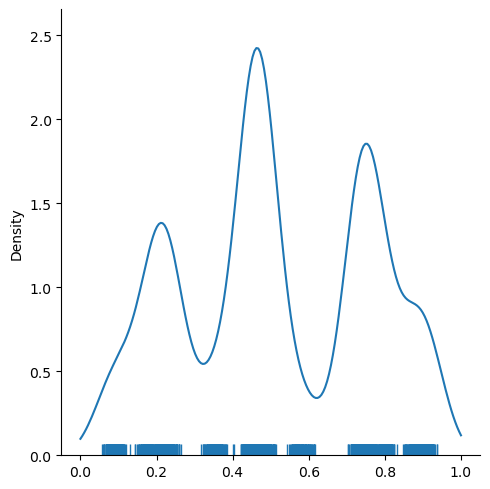

In [35]:
sns.displot(
    sampled_choices_base['selection'].mean(0),
    kind='kde',
    rug=True,
    clip=[0,1]
)

Model lr argstrength test:

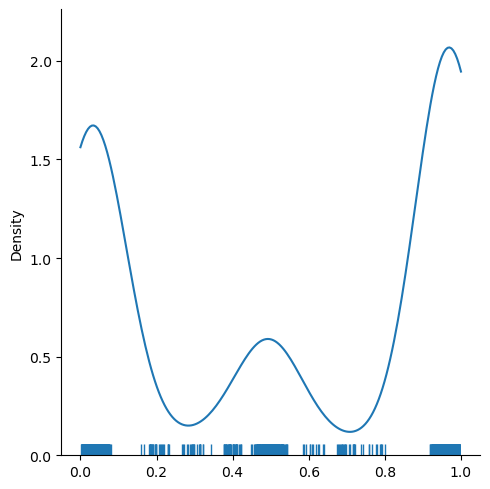

In [36]:
sns.displot(
    sampled_choices_lr_argstrength['selection'].mean(0),
    kind='kde',
    rug=True,
    clip=[0,1]
)

Model maximin argstrength test:

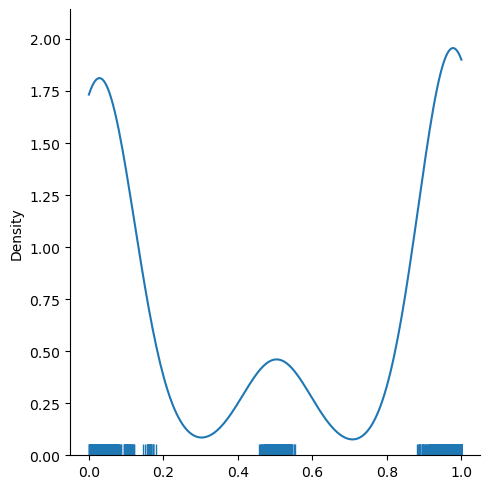

In [37]:
sns.displot(
    sampled_choices_maximin_argstrength['selection'].mean(0),
    kind='kde',
    rug=True,
    clip=[0,1]
)

Model prag argstrength test:

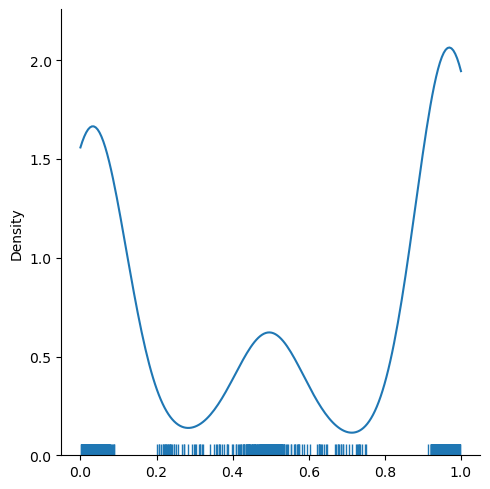

In [38]:
sns.displot(
    sampled_choices_prag_argstrength['selection'].mean(0),
    kind='kde',
    rug=True,
    clip=[0,1]
)

Model nonparametric argstrength test:

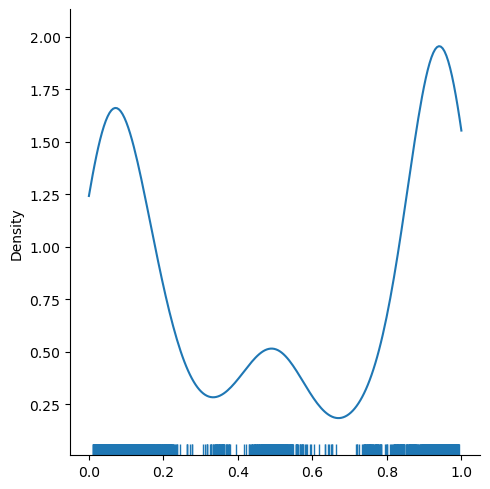

In [39]:
sns.displot(
    sampled_choices_nonparametric_argstrength['selection'].mean(0),
    kind='kde',
    rug=True,
    clip=[0,1]
)

### Hierarchical models

**Base**

In [40]:
model_base_hierarchical = factory_model_base_hierarchical(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

Defining hierarchical model
 __str__ = [0.18274435 0.81725565]


Sometimes this raises a `ValueError: probabilities contain NaN` error. This was caused by the fact that to keep $\alpha$ above 1, I exp it, which however causes overflow problems as it easily gets very high values. To fix this I just reduced the means of the pop level alpha and of the zs. This wasn't a big problem in the other version because I didn't need to do big prior predictive checks so I erred on the side of too-wide priors.

In [183]:
with model_base_hierarchical:
    sampled_choices_base_hierarchical = pm.sample_prior_predictive(samples=100)

**Log-likelihood ratio argstrength**

In [208]:
model_lr_argstrength_hierarchical = factory_model_lr_argstrength_hierarchical(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

Defining hierarchical model
Defining hierarchical model


In [213]:
with model_lr_argstrength_hierarchical:
    sampled_choices_lr_argstrength_hierarchical = pm.sample_prior_predictive(
        samples=100,
        # var_names=['alpha', 'beta']
    )

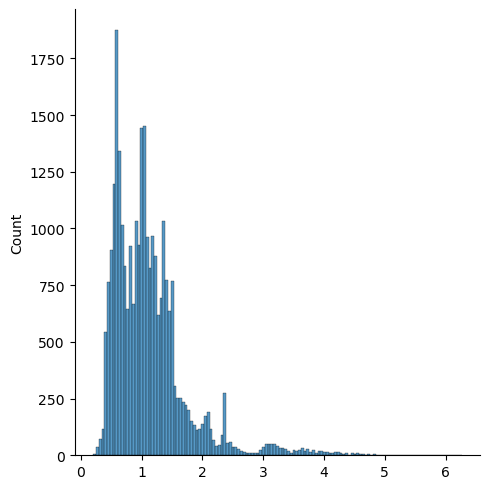

In [210]:
sns.displot(sampled_choices_lr_argstrength_hierarchical['alpha'].flatten())

**Maximin argstrength**

In [215]:
model_maximin_argstrength_hierarchical = factory_model_maximin_argstrength_hierarchical(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

/tmp/ipykernel_621/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Defining hierarchical model
Defining hierarchical model


In [216]:
with model_maximin_argstrength_hierarchical:
    sampled_choices_maximin_argstrength_hierarchical = pm.sample_prior_predictive(
        samples=100,
        # var_names=['alpha', 'beta']
    )

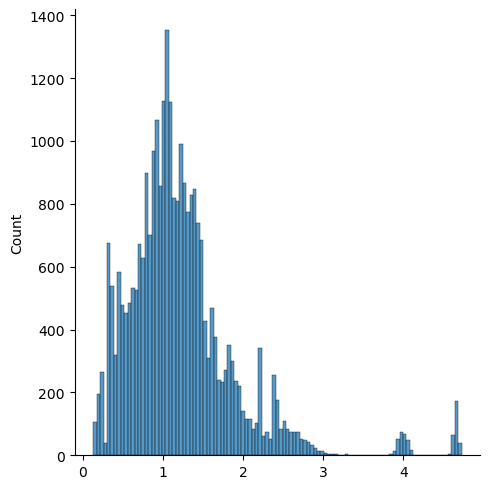

In [217]:
sns.displot(sampled_choices_maximin_argstrength_hierarchical['alpha'].flatten())

**$S_1$ argstrength**

In [225]:
model_prag_argstrength_hierarchical = factory_model_prag_argstrength_hierarchical(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

Defining hierarchical model
Defining hierarchical model
Defining hierarchical model
Defining hierarchical model


In [226]:
with model_prag_argstrength_hierarchical:
    sampled_choices_prag_argstrength_hierarchical = pm.sample_prior_predictive(
        samples=100,
        # var_names=['alpha', 'beta']
    )

In [229]:
sampled_choices_maximin_argstrength_hierarchical['alpha'].shape

(100, 282)

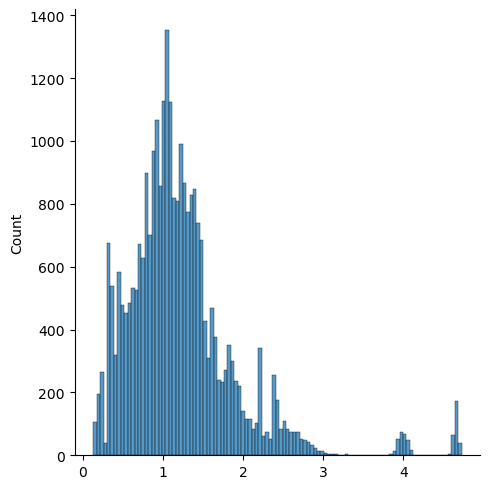

In [233]:
sns.displot(sampled_choices_maximin_argstrength_hierarchical['alpha'].flatten())

**Nonparametric argstrength**

In [240]:
model_nonparametric_argstrength_hierarchical = factory_model_nonparametric_argstrength_hierarchical(
    possible_trials, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

Defining hierarchical model
Defining hierarchical model


In [241]:
with model_nonparametric_argstrength_hierarchical:
    sampled_choices_nonparametric_argstrength_hierarchical = pm.sample_prior_predictive(
        samples=100,
        # var_names=['alpha', 'beta']
    )

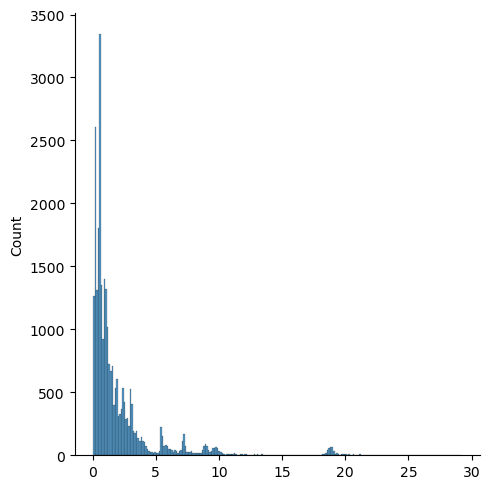

In [243]:
sns.displot(sampled_choices_nonparametric_argstrength_hierarchical['alpha'].flatten())

## Find a good design with simulations of completely random trials

In [42]:
shown_left, shown_right, utterances, index_utterance = [], [], [], []
for i, utt_comp in enumerate(utterance_observation_compatibility):
    possible_array_indices = np.argwhere(utt_comp).flatten()
    
    # check that this utterance has at least
    # two compatible states
    if len(possible_array_indices) > 2:
        
        # choose a random array 
        # compatible with the utterance
        left, right = np.random.choice(
            possible_array_indices,
            size=2,
            replace=False
        )
        
        shown_left.append(left)
        shown_right.append(right)
        utterances.append(possible_utterances[i])
        index_utterance.append(i)

# response gets sampled by the prior predictive
utterances = np.apply_along_axis(
    lambda x: '|'.join(x),
    1,
    utterances,
)
index_utterance = np.array(
    index_utterance
)
condition = np.random.choice(
    [0,1],
    size=len(index_utterance)
)

In [43]:
fake_data = pd.DataFrame({
    'left': shown_left,
    'right': shown_right,
    'utterance': utterances,
    'index_utterance': index_utterance,
    'condition': condition
})

In [44]:
fake_data_model = factory_model_base(
    fake_data, 
    possible_observations, 
    possible_utterances,
    include_observed=False
)

Defining non-hierarchical model
 __str__ = [ 2 26]


In [45]:
with fake_data_model:
    sampled_choices = pm.sample_prior_predictive()

In [46]:
sampled_choices.keys()

dict_keys(['costnone_log__', 'selection', 'alpha_interval__', 'costnone', 'alpha'])

In [47]:
sampled_choices['selection'].shape

(500, 26)

In [48]:
sampled_choices['selection'].mean(0)

array([0.762, 0.792, 0.404, 0.136, 0.9  , 0.77 , 0.252, 0.184, 0.736,
       0.762, 0.86 , 0.734, 0.14 , 0.738, 0.148, 0.592, 0.492, 0.24 ,
       0.736, 0.11 , 0.868, 0.614, 0.526, 0.49 , 0.876, 0.856])

## Find a good design with simulations of all _possible_ trials

### Save random set of trials to test the magpie experiment

The magpie experiment needs a json file that defines the trials to show to the participant. If I use the optimal Bayesian design strategy described below, these json files will need to be generated from a script. This section tests the creation of these files manually to check if they work with the experiment.

In order to be compatible with the magpie experiment, the trials file has to be a json containing a list, where each list element is a dictionary encoding a trial with values:
- studentsArrayRight: e.g. this is a list that looks like [ 12, 12, 9, 0, 0 ]
- studentsArrayLeft
- nQuestions
- names: a list with one name per element of studentsArrayRight
- condition: 0 (low) or 1 (high)
- utterance: full utterance, e.g., "Most of the students got some of the questions right"

In [39]:
import json

In [47]:
def construct_magpie_trial(t):
    # t is the trial as encoded in the dataframe above
    a, b, c = t['utterance'].split('|')
    return {
        'studentsArrayRight': possible_observations[t['right']].tolist(),
        'studentsArrayLeft': possible_observations[t['left']].tolist(),
        'nQuestions': 12,
        'names': ['John', 'John', 'John', 'John', 'John'],
        'condition': t['condition'],
        'utterance': f'{a.capitalize()} of the students got {b} of the questions {c}'
    }

In [48]:
# selects 20 random trials
random_trials = possible_trials.iloc[np.random.choice(
    np.arange(len(possible_trials)), 
    size=20,
    replace=False
)].reset_index(drop=True)

In [49]:
# path to the appropriate folder
# in the magpie experiment
exp_trials_path = (
    '/mnt/c/Users/faust/Documents/arglang_exp/'
    'listener_side/trials/trials.json'
)

In [50]:
# the json is a list of dicts, 
# where each dict encodes a trial
trials_for_magpie = [
    construct_magpie_trial(v) 
    for v 
    in random_trials.T.to_dict().values()
]

In [51]:
trials_for_magpie[0]

{'studentsArrayRight': [9, 9, 9, 0, 0],
 'studentsArrayLeft': [9, 9, 9, 3, 3],
 'nQuestions': 12,
 'names': ['John', 'John', 'John', 'John', 'John'],
 'condition': 0,
 'utterance': 'All of the students got some of the questions wrong'}

In [52]:
with open(exp_trials_path, 'w') as openfile:
    json.dump(
        trials_for_magpie,
        openfile
    )

### Calculate expected infogain

- Above, we approximated the (prior) probability of each answer for each model for each possible trial, marginalized across all other parameters (e.g., $\alpha$). 
- For each possible input trial and each possible answer (left and right), we can calculate the approximate prior and posterior over models assuming we got that answer in that trial. 
- Once we have this, we can calculate the infogain for each possible trial&answer (assuming a uniform initial distribution over models) as the KL from the prior to the posterior distributions (over models).
- Then, we can calculate the _expected_ infogain of a trial as the expected value (across possible answers) of the infogain of that trial&answer.
    - Note that the marginal probability of an answer is $P(A | \zeta) = \sum_{\text{model } m} P(m) P(A \mid m, \zeta) = \sum_{\text{model } m} P(m) \int P(A \mid m, \zeta, \theta_m) P(\theta_m \mid m) d\theta_m$
    - Where $\zeta$ is the design, i.e. the series of trials, and $\theta$ refers to the joint parameters for model $m$

In [331]:
# jit(nopython=True)
def calculate_expected_infogain_full(prior_answer_p, prior=None, full_output=False):
    """
    NOTE: Use the version below which has simpler code.
    THe simplification is explained in the maths in the next subsection.
    
    prior_answer_p: array
        Dimensions: (possible answer set, experiment, model)
        and contains the likelihood, i.e. the probability of each
        answer(set) in the trial for each model.
        Experiment can consist of just one trial.
        Answer sets are the possible total behaviours of the participants.
        There can be e.g. two values in possible answer dimension: "left" and "right".
    prior: array
        The prior probability of each model
    Returns
    -------
    array or set of arrays
        expected_infogain: array with dimension (experiment),
        which can be 1 if I only want the expected infogain of one experiment
    """

    if prior is None:
        # create a uniform prior if one is not given
        prior = (
            np.ones(prior_answer_p.shape) 
            / prior_answer_p.shape[-1]
        )
    
    unnorm_posterior = (
        prior_answer_p * prior
    )
    
    # Calculate the posterior over models for each trial given each answer 
    posterior_given_answer = (
        unnorm_posterior 
        / unnorm_posterior.sum(-1,keepdims=True)
    )

    # Calculate the KL divergence from prior to posterior (over models)
    # given each possible answer in each trial
    # Dimensions: (answer, trial)
    kls = (
        posterior_given_answer * (np.log(posterior_given_answer) - np.log(prior))
    # sum over models
    ).sum(-1)

    # NOTE: weight is P(A) = \sum_{model m} P(m) P(A | m)
    # where P(m) is the current prior over models
    # Dimensions: (answer, trial)
    p_answer = (
        # P(A|m)
        # (answer, trial, model)
        prior_answer_p 
        # P(m)
        # (model)
        * prior
    # sum over models
    ).sum(-1)
    
    # calculate the expected KL (over possible answers)
    # dimensions: (trial)
    expected_infogain = (
        p_answer * kls 
    ).sum(0)
    
    if full_output:
        return (
            posterior_given_answer, 
            kls,
            expected_infogain
        )
    else:
        return expected_infogain


# jit(nopython=True)
def calculate_expected_infogain(prior_answer_p, prior=None, full_output=False):
    """
    prior_answer_p: array
        Dimensions: (possible answer, possible trial, model)
        and contains the likelihood, i.e. the probability of each
        answer in the trial for each model
    prior: array
        The prior probability of each model
    """

    if prior is None:
        # create a uniform prior if one is not given
        prior = (
            np.ones(prior_answer_p.shape) 
            / prior_answer_p.shape[-1]
        )
    
    unnorm_posterior = (
        prior_answer_p * prior
    )
    
    # Calculate the posterior over models for each trial given each answer 
    posterior_given_answer = (
        unnorm_posterior / unnorm_posterior.sum(-1,keepdims=True)
    )

    # Calculate the KL divergence from prior to posterior (over models)
    # given each possible answer in each trial.
    # NOTE: Using simplified kl here
    # Dimensions: (answer, trial)
    kls = (
        unnorm_posterior * np.log(posterior_given_answer / prior)
    # sum over models
    ).sum(-1)
    
    # calculate the expected KL (over possible answers)
    # dimensions: (trial)
    expected_infogain = kls.sum(0)
    
    if full_output:
        return (
            posterior_given_answer, 
            kls,
            expected_infogain
        )
    else:
        return expected_infogain

### Generate experiments w/ static (batch / open-loop) design; individual-trial optimization

In static experiment optimized trial-wise, we sample a bunch of trials proportionally to their individual expected infogain and run an experiment consisting of those trials. These have a disadvantage over design where we calculate infogain of whole _sequence of trials_: the trials with the highest infogain might be mostly focused on distinguishing between two specific models, for which the early trials might already be enough. 

In [57]:
from arviz import plot_pair

In [92]:
# for each model, the probability of answering with 
# the image presented on the right for each possible trial
# NOTE: In this design, there simply two possible answers
prior_answer_right_p_dict = {
    'base': sampled_choices_base['selection'].mean(0),
    'lr_argstrength': sampled_choices_lr_argstrength['selection'].mean(0),
    'maximin_argstrength': sampled_choices_maximin_argstrength['selection'].mean(0),
    'prag_argstrength': sampled_choices_prag_argstrength['selection'].mean(0),
    'nonparametric_argstrength': sampled_choices_nonparametric_argstrength['selection'].mean(0)
}

df_prior_answers_right_p = pd.DataFrame(prior_answer_right_p_dict)
prior_answers_right_p = df_prior_answers_right_p.values

In [66]:
prior_answer_p = np.stack((
    # answer "left"
    1-df_prior_answers_right_p.values,
    # answer "right"
    df_prior_answers_right_p.values
))

In [67]:
prior_answer_p

array([[[0.915, 0.038, 0.033, 0.04 , 0.071],
        [0.841, 0.034, 0.02 , 0.03 , 0.068],
        [0.53 , 0.057, 0.029, 0.058, 0.174],
        ...,
        [0.118, 0.801, 0.94 , 0.77 , 0.912],
        [0.136, 0.607, 0.834, 0.559, 0.842],
        [0.628, 0.2  , 0.034, 0.269, 0.067]],

       [[0.085, 0.962, 0.967, 0.96 , 0.929],
        [0.159, 0.966, 0.98 , 0.97 , 0.932],
        [0.47 , 0.943, 0.971, 0.942, 0.826],
        ...,
        [0.882, 0.199, 0.06 , 0.23 , 0.088],
        [0.864, 0.393, 0.166, 0.441, 0.158],
        [0.372, 0.8  , 0.966, 0.731, 0.933]]])

In [68]:
posterior_given_answer, kls, expected_infogain = calculate_expected_infogain_full(
    prior_answer_p, 
    full_output=True
)

In [69]:
posterior_given_answer, kls, expected_infogain_simplified = calculate_expected_infogain(
    prior_answer_p, 
    full_output=True
)

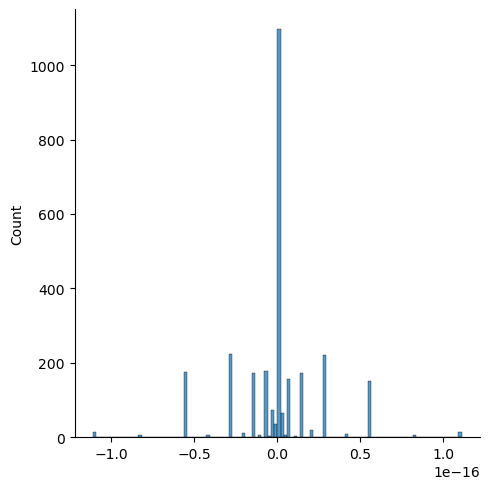

In [70]:
sns.displot(expected_infogain- expected_infogain_simplified)

In [234]:
posterior_given_answer_left, posterior_given_answer_right = posterior_given_answer
kl_left, kl_right = kls

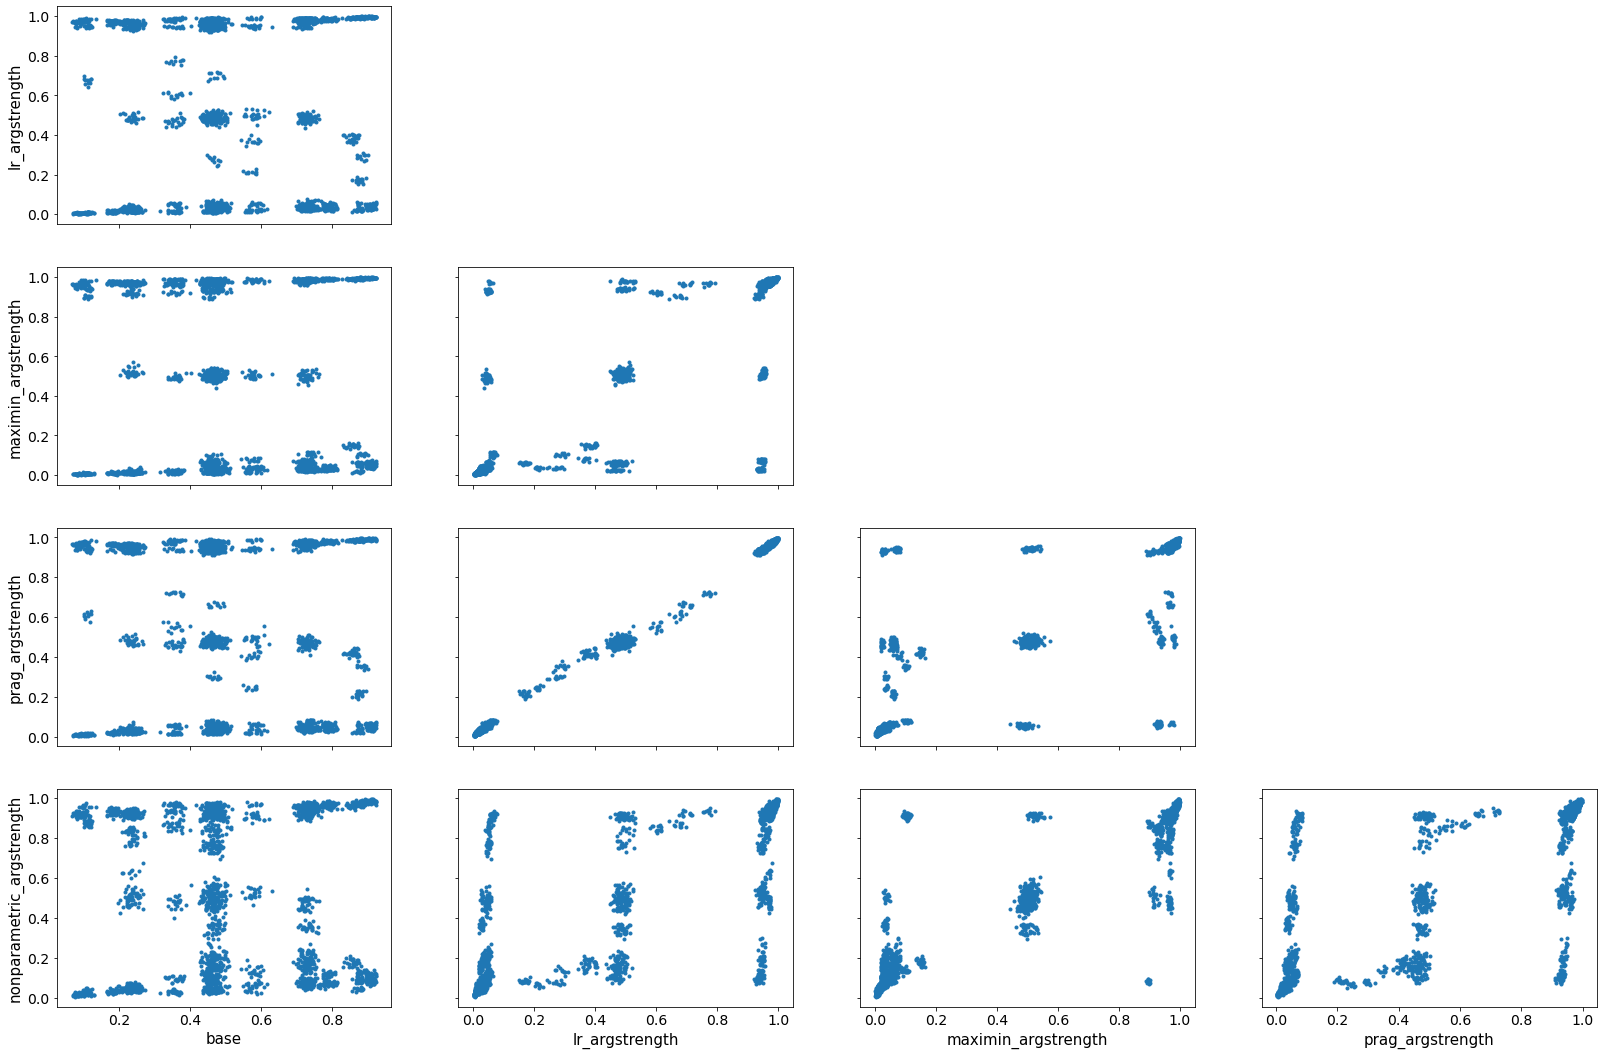

In [235]:
# Show the joint prediction for each combination of modelsb
plot_pair(prior_answer_right_p)
plt.show()

In [116]:
df_prior_answers_right_p

,base,lr_argstrength,maximin_argstrength,prag_argstrength,nonparametric_argstrength
0,0.093,0.974,0.956,0.956,0.924
1,0.195,0.973,0.982,0.968,0.934
2,0.475,0.956,0.960,0.934,0.806
3,0.246,0.962,0.967,0.951,0.812
4,0.252,0.955,0.963,0.943,0.934
...,...,...,...,...,...
2815,0.447,0.296,0.030,0.302,0.072
2816,0.379,0.601,0.928,0.533,0.822
2817,0.874,0.152,0.067,0.214,0.078
2818,0.851,0.362,0.154,0.424,0.208


<AxesSubplot:ylabel='Density'>

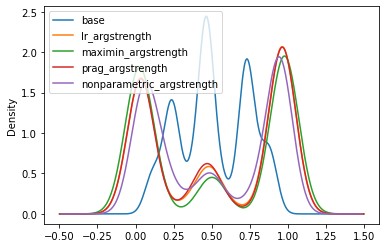

In [79]:
df_prior_answers_right_p.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

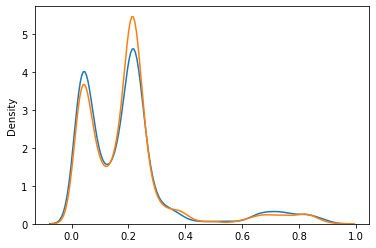

In [118]:
sns.kdeplot(posterior_given_answer_left.flatten())
sns.kdeplot(posterior_given_answer_right.flatten())

<AxesSubplot:ylabel='Density'>

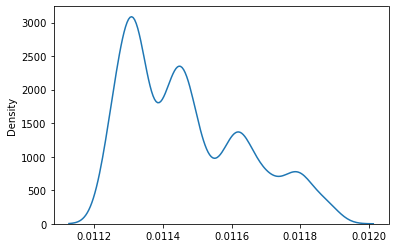

In [119]:
sns.kdeplot(expected_infogain)

In [125]:
argmax_infogain = expected_infogain.argmax()
print(argmax_infogain, max(expected_infogain))
display(possible_trials.iloc[argmax_infogain])
display(posterior_given_answer_left[argmax_infogain])
display(posterior_given_answer_right[argmax_infogain])

2127 0.011905754191082193


left                             8
right                           11
utterance          some|most|right
index_utterance                 12
condition                        1
Name: 2127, dtype: object

array([0.19581524, 0.37623371, 0.00750099, 0.37228583, 0.04816423])

array([0.20429672, 0.01905148, 0.39764897, 0.02310499, 0.35589785])

In [240]:
(prior_answer_p == 0).sum()

0

In [241]:
(posterior_given_answer_right == 0).sum()

0

### Generate experiments w/ static (batch / open-loop) design; batch optimization w/ simulated annealing

> NOTE: Uses objects produced above in Prior Predictive Checks with Pooled models

In this version of the design, we find a whole sequence of $n$ trials that (approximately) maximizes the expected infogain. 

For a given experiment (defined as a series of trials), we need to calculate the _expected_ infogain across all possible series of answers. 
- To do this, we need the probability of each set of answers for the experiment, and there are $2^n$ many (left/right for each trial). 
- The probability of a set of answers for an experiment for a model is the product of the probability of each answer in response to each of the experiment's trial, since we assume that they are independent given the participant's parameters. Formally, the probability of a series of answers for a specific experiment $\zeta$ is:

\begin{align}
P(a | \zeta) 
&= \sum_{\text{model } m} P(m) P(a \mid m, \zeta) \\
&= \sum_{\text{model } m} P(m) \int P(a \mid m, \zeta, \theta_m) P(\theta_m \mid m) d\theta_m \\
&= \sum_{\text{model } m} P(m) \int P(\theta_m \mid m) \prod_i P(a_i \mid m, \zeta, \theta_m) d\theta_m \\
\end{align}

And the expected infogain is calculated as:

\begin{align}
\text{EIG}(\zeta) 
&= \sum_{\text{answer set } a} P(a \mid \zeta) \text{KL}( P(m \mid a, \zeta) \mid P(m \mid \zeta) ) \\
&= \sum_{\text{answer set } a} P(a \mid \zeta) \sum_m P(m \mid a, \zeta) \log \left( P(m \mid a, \zeta) \frac{1}{P(m \mid \zeta) }\right) \\
&= \sum_{\text{answer set } a} P(a \mid \zeta) \sum_m P(m \mid a, \zeta) \log \left( \frac{P(a \mid m, \zeta)P(m \mid \zeta)}{P(a \mid \zeta)} \frac{1}{P(m \mid \zeta) }\right) \\
&= \sum_{\text{answer set } a} P(a \mid \zeta) \sum_m \frac{P(a \mid m, \zeta)P(m \mid \zeta)}{P(a \mid \zeta)} \log \left( \frac{P(a \mid m, \zeta)}{P(a \mid \zeta)} \right) \\
&= \sum_{\text{answer set } a} \sum_m P(a \mid m, \zeta)P(m ) \log \left( \frac{P(a \mid m, \zeta)}{P(a \mid \zeta)} \right)
\end{align}

where $\zeta$ is the design, i.e. a series of trials, where each trial is a tuple (left image, right image, sentence, condition), and there are 2820 such trials.

Problems
- There are waaaay too many possible experiments to find the _optimal_ one for any large enough number of trials. There are 2820 total possible trials. Then for e.g. 30 trials there are 2820!/(2820-30)! many possible trials, which is a HUGE number. But many of those aren't going to be very good. 
    - One solution is to run simulated annealing to find some good designs
    - The energy function for the simulated annealing would be the expected (across possible answers) infogain of the experiment.
- It's really hard to calculate the marginal likelihood $P(a \mid m, \zeta)$ as defined above.
    - I need to approximate this:
$$
\mathbb{E}_{P(\theta_m \mid m)} \left[ \prod_i P(a_i \mid m, \zeta, \theta_m) \right]
$$
    - In theory, I could take a $N$ prior samples of whole experiments and consider the proportion of each series, like:
$$
\approx \frac{1}{N} \sum_{j=1}^N \prod_i P(a_i \mid m, \zeta, \theta_m)
$$
    - I have for each datapoint $a_i$, with $N$ prior samples:
$$
\frac{1}{N} \sum_{j=1}^N P(a_i \mid m, \zeta, \theta_j) \approx \mathbb{E}_{P(\theta_m \mid m)} \left[ P(a_i \mid m, \zeta, \theta_m) \right]
$$
    - And I can approximately calculate
$$
\prod_i \mathbb{E}_{P(\theta_m \mid m)} \left[ P(a_i \mid m, \zeta, \theta_m) \right]
$$
    - So I am approximating a sum of products with a product of sums

In [325]:
import simanneal
from simanneal import Annealer

In [326]:
from itertools import product

In [432]:
def calculate_loglikelihood_answerset(possible_answers, prior_answers_right_p, trials):
    # calculate the likelihood of each possible series of answer
    # for each trial under each model in the actual experiment
    # (which encodes the independent variable values for each trial)
    # Dims (answerset, trial in experiment, model)
    prior_answerset_logp = np.log(np.where(
        # dims (possible answerset, trial index, 1)
        possible_answers[:,:,None],
        # prob of answering left for each trial for each model
        # dims (experiment trial, model)
        1-prior_answers_right_p[trials],
        # prob of answering right for each trial for each model
        # dims (experiment trial, model)
        prior_answers_right_p[trials]
    ))
    return prior_answerset_logp

@jit(nopython=True)
def update_loglikelihood_answerset(i, 
                                   index_to_replace,
                                   mask, 
                                   prior_answers_right_p=np.array([[]])):
    
    values = prior_answers_right_p[i]
    # probs = np.where(
    #     mask,
    #     1-values,
    #     values
    # )
    
    # using this formulation because it's easier for Numba
    probs = mask * (1-values) + (1-mask) * values
    return np.log(probs)

In [433]:
class Optimizer(Annealer):
    
    # Max (starting) and min (ending) temperature
    # I calibrated them manually to go 
    # from about 100% to 0% acceptance rates
    Tmax = 0.3
    Tmin = 0.01     
    # Number of iterations
    # About 7 minutes per 1k steps
    steps = 1000   
    # Number of updates (by default an update prints to stdout)
    updates = 100   
    
    def __init__(self, state, prior_answers_right_p, possible_answers):
        self.prior_answers_right_p = prior_answers_right_p
        self.possible_answers = possible_answers
        # this is to record the prior_answerset_p of current state
        # Dims (answerset, experiment trial, model)
        self.prior_answerset_logp = calculate_loglikelihood_answerset(
            possible_answers, 
            prior_answers_right_p, 
            state
        )
        super(Optimizer, self).__init__(state)
    
    def move(self):
        """
        Swap one trial for another.
        
        NOTE: Return value (if given) is interpreted as a delta in energy.
        """
        
        # pick index of random trial to replace
        index_to_replace = np.random.choice(len(self.state))
        
        # pick random trial to add to experiment in place of old one
        i = np.random.choice(len(self.prior_answers_right_p))
        
        # change until you find something that's not in array
        # NOTE: This is fast because there are few trials in experiment
        # compared to the number of possible trials
        while i in self.state:
            i = np.random.choice(len(self.prior_answers_right_p))
            
        # update the prior loglikelihood of the changed trial
        # to the one in the new experiment 
        # shape (answerset, trial in experiment, model)  
        self.prior_answerset_logp[:,index_to_replace] = update_loglikelihood_answerset(
            mask=self.possible_answers[:,index_to_replace,np.newaxis], 
            prior_answers_right_p=self.prior_answers_right_p, 
            i=i, 
            index_to_replace=index_to_replace
        )
            
        # replace random trial with different trial that's not yet in experiment
        self.state[index_to_replace] = i

    def energy(self):
        """Calculates the expected infogain"""
        infogain = calculate_expected_infogain(
            # None gets it to Dimension: (answer sets, 1, model)
            # Contains probability of each answer (set) given each model 
            # for the single experiment I am considering (identified as a series of trials)
            np.exp(self.prior_answerset_logp.sum(1))
            [:,None,:]
        )
        # print(self.state, infogain)
        # return the negative infogain since the algo 
        # tries to _minimize_ the temperature
        return - infogain
    
    def copy_state(self, state):
        # copy is true by default for np.array
        return np.array(state)

In [434]:
n_trials = 20
# all the possible answer sets that the participant
# could give, encoded as a series of 0s (left) and 1s (right)
possible_answers = np.array(list(product(
    [0,1],
    repeat=n_trials
)))

In [439]:
df_prior_answers_right_p

,base,lr_argstrength,maximin_argstrength,prag_argstrength,nonparametric_argstrength
0,0.088,0.972,0.971,0.966,0.932
1,0.210,0.962,0.986,0.958,0.939
2,0.440,0.955,0.975,0.929,0.826
3,0.240,0.961,0.976,0.946,0.826
4,0.263,0.957,0.977,0.946,0.926
...,...,...,...,...,...
2815,0.497,0.278,0.031,0.303,0.070
2816,0.348,0.612,0.933,0.564,0.845
2817,0.875,0.177,0.051,0.207,0.073
2818,0.844,0.394,0.144,0.449,0.195


Find the underlying distribution of expected infogains, to get an idea of how well the optimizer is performing:

In [444]:
prior_answers_right_p = df_prior_answers_right_p.values

In [445]:
exp_infogains = []
for i in range(300):
    trials = np.random.choice(
        len(prior_answers_right_p), 
        size=n_trials
    )
    
    prior_answerset_logp = calculate_loglikelihood_answerset(
        possible_answers, 
        prior_answers_right_p, 
        trials
    )
    exp_infogains.append(
        calculate_expected_infogain(
            np.exp(prior_answerset_logp.sum(1))
            [:,None,:]
        )
    )
    print(i, end=', ')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

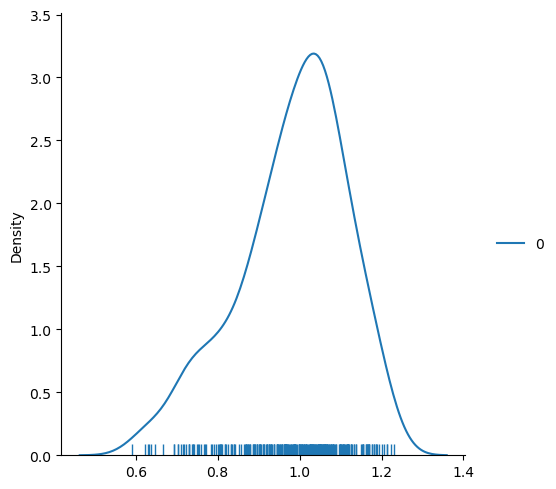

In [446]:
sns.displot(
    np.array(exp_infogains),
    kind='kde',
    rug=True
)

Find (approximated) optimal design starting with uniform prior over models:

In [447]:
# create random initial experiment
# containing the index of one trial for each trial 
# in the experiment
trials = np.random.choice(
    len(df_prior_answers_right_p), 
    size=n_trials
)

In [448]:
optimizer = Optimizer(
    trials,
    df_prior_answers_right_p.values,
    possible_answers
)

In [449]:
# Find approximated optimal design and associated infogain
optimal_design, negative_infogain = optimizer.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.01000         -1.14     0.00%     0.00%     0:07:41     0:00:00

In [452]:
print(optimal_design, negative_infogain)

[  34  180 1588  802 2484 2409  408 2745  800 2034 1553 2819 2489 1302
 1945  321  119 1979 1031  311] [-1.26136621]


### Recovery tests with random trials vs. approximately optimal design

In [453]:
from collections import defaultdict

In [454]:
n_samples = 100

In [466]:
optimal_design

array([  34,  180, 1588,  802, 2484, 2409,  408, 2745,  800, 2034, 1553,
       2819, 2489, 1302, 1945,  321,  119, 1979, 1031,  311])

In [465]:
data

,left,right,utterance,index_utterance,condition,id,response
34,8,16,none|none|right,0,0,3,1
180,8,15,none|all|wrong,7,0,18,0
1588,8,12,none|all|wrong,7,1,158,1
802,6,12,some|most|wrong,13,0,80,1
2484,12,18,most|some|right,18,1,248,1
2409,4,9,most|some|right,18,1,240,1
408,9,10,some|some|right,10,0,40,1
2745,7,14,all|some|right,26,1,274,1
800,6,10,some|most|wrong,13,0,80,0
2034,0,1,some|most|right,12,1,203,0


In [472]:
prior_samples

{'beta_interval__': array([2.53991801]),
 'selection': array([[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]]),
 'beta': array([0.92689327]),
 'alpha_interval__': array([-0.78623376]),
 'costnone_log__': array([-0.60100975]),
 'costnone': array([0.54825775]),
 'alpha': array([1.56488963])}

In [482]:
results = dict()

# assuming that each model is the true one in turn
for name_true, factory_true in model_factories.items():
        
    # note: data doesn't have the dependent variable yet!
    # Because it's not needed for prior samples
    data = possible_trials.iloc[optimal_design]
    
    # define the true model with the "optimal" design
    true_model = factory_true(
        data, 
        possible_observations, 
        possible_utterances,
        include_observed=False
    )
    
    # take some prior samples of the independent variable
    # to recover
    with true_model:
        prior_samples = pm.sample_prior_predictive(samples=1)
        
    subresults = defaultdict(list)
    for i, sample in enumerate(prior_samples['selection']):
        
        true_values = {
            k:v[i]
            for k,v 
            in prior_samples.items()
            if k!='selection'
        }
        
        # put prior sample in data
        data.loc[:,'response'] = sample
        
        # find posterior for each possible model
        for name, factory_infer in model_factories.items():
            print(f'\n\nFinding posterior for true {name_true} with {name}')
            model = factory_infer(
                data,
                possible_observations, 
                possible_utterances
            )
            with model:
                # trace = pm.sample(
                #     return_inferencedata=True,
                #     target_accept=0.99
                # )
                MAP = pm.find_MAP(progressbar=False)
            
            subresults[name].append({
                'MAP': MAP,
                'true': true_values
            })
            
    # add result to results dict
    results[name_true] = subresults  

Defining non-hierarchical model
 __str__ = [ 2 20]


Finding posterior for true base with base
Defining non-hierarchical model
 __str__ = [ 2 20]


/tmp/ipykernel_621/2304865398.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'response'] = sample




Finding posterior for true base with lr_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true base with maximin_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


/tmp/ipykernel_621/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)




Finding posterior for true base with prag_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true base with nonparametric_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true lr_argstrength with base


/tmp/ipykernel_621/2304865398.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'response'] = sample


Defining non-hierarchical model
 __str__ = [ 2 20]


Finding posterior for true lr_argstrength with lr_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true lr_argstrength with maximin_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


/tmp/ipykernel_621/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)




Finding posterior for true lr_argstrength with prag_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true lr_argstrength with nonparametric_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


/tmp/ipykernel_621/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true maximin_argstrength with base


/tmp/ipykernel_621/2304865398.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'response'] = sample


Defining non-hierarchical model
 __str__ = [ 2 20]


Finding posterior for true maximin_argstrength with lr_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true maximin_argstrength with maximin_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


/tmp/ipykernel_621/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)




Finding posterior for true maximin_argstrength with prag_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true maximin_argstrength with nonparametric_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true prag_argstrength with base


/tmp/ipykernel_621/2304865398.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'response'] = sample


Defining non-hierarchical model
 __str__ = [ 2 20]


Finding posterior for true prag_argstrength with lr_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true prag_argstrength with maximin_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


/tmp/ipykernel_621/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)




Finding posterior for true prag_argstrength with prag_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true prag_argstrength with nonparametric_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true nonparametric_argstrength with base


/tmp/ipykernel_621/2304865398.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'response'] = sample


Defining non-hierarchical model
 __str__ = [ 2 20]


Finding posterior for true nonparametric_argstrength with lr_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true nonparametric_argstrength with maximin_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


/tmp/ipykernel_621/278256974.py:58: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)




Finding posterior for true nonparametric_argstrength with prag_argstrength
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


Finding posterior for true nonparametric_argstrength with nonparametric_argstrength
Defining non-hierarchical model
Defining non-hierarchical model


In [483]:
pprint(results)

{'base': defaultdict(<class 'list'>,
                     {'base': [{'MAP': {'alpha': array(0.00011049),
                                        'alpha_interval__': array(-10.7199592),
                                        'costnone': array(8.13051381e-06),
                                        'costnone_log__': array(-11.71988644)},
                                'true': {'alpha': 1.2607999592645154,
                                         'alpha_interval__': -1.0871252878843864,
                                         'costnone': 1.1400539340991374,
                                         'costnone_log__': 0.1310755719005707}}],
                      'lr_argstrength': [{'MAP': {'alpha': array(0.20749718),
                                                  'alpha_interval__': array(-3.13969032),
                                                  'beta': array(0.97298141),
                                                  'beta_interval__': array(3.58383998),
                    

#### Is it possible to calculate $\delta$ of infogain? (Notation to rewite!)

Now we ask: what is the $\delta$ in expected infogain between two experiments $\zeta^1$ and $\zeta^2$ that only differ wrt to a single trial $k$? This is useful because some libraries for simulated annealing allow us to simply use the _difference_ in energy between states rather than the absolute states, and the former can be much less computationally expensive to calculate.

\begin{align}
\text{EIG}(\zeta^1) - \text{EIG}(\zeta^2)  
&= \sum_{\text{answer set } a} \sum_m P(a \mid m, \zeta^1)P(m) \log \left( \frac{P(a \mid m, \zeta^1)}{P(a \mid \zeta^1)} \right) - P(a \mid m, \zeta^2)P(m) \log \left( \frac{P(a \mid m, \zeta^2)}{P(a \mid \zeta^2)} \right) \\
&= \sum_{\text{answer set } a} \sum_m P(a \mid m, \zeta^1)\log \left( \frac{P(a \mid m, \zeta^1)}{P(a \mid \zeta^1)} \right) - P(a \mid m, \zeta^2)\log \left( \frac{P(a \mid m, \zeta^2)}{P(a \mid \zeta^2)} \right) \\
&= \sum_{\text{answer set } a} \sum_m \left( \prod_{i} P(a_i \mid m, \zeta^1_i) \right) \log \left( \frac{\prod_{i} P(a_i \mid m, \zeta^1_i)}{P(a \mid \zeta^1)} \right) -  \left( \prod_{i} P(a_i \mid m, \zeta^2_i) \right) \log \left( \frac{\prod_{i} P(a_i \mid m, \zeta^2_i) }{P(a \mid \zeta^2)} \right)
\end{align}

assuming a uniform prior distribution over models.

$$
= \sum_{\text{answer set } a} \sum_m 
    \left( P(a_k \mid m, \zeta^1_k) \prod_{i/k} P(a_i \mid m, \zeta^1_i) \right) 
        \log \left( \frac{P(a_k \mid m, \zeta^2_k) \prod_{i/k} P(a_i \mid m, \zeta^1_i)}{P(a \mid \zeta^1)} \right) 
    -\left( P(a_k \mid m, \zeta^2_k) \prod_{i/k} P(a_i \mid m, \zeta^2_i) \right) 
        \log \left( \frac{P(a_k \mid m, \zeta^2_k) \prod_{i/k} P(a_i \mid m, \zeta^2_i)}{P(a \mid \zeta^2)} \right)
$$

and since by assumption $\prod_{i/k} P(a_i \mid m, \zeta^1_i) = \prod_{i/k} P(a_i \mid m, \zeta^2_i)$

$$
\small
= \sum_{\text{answer set } a} \sum_m 
\left(\prod_{i/k} P(a_i \mid m, \zeta^1_i)\right) \left(
    P(a_k \mid m, \zeta^1_k) 
        \log \left( \frac{P(a_k \mid m, \zeta^2_k) \prod_{i/k} P(a_i \mid m, \zeta^1_i)}{P(a \mid \zeta^1)} \right)
    -P(a_k \mid m, \zeta^2_k)
        \log \left( \frac{P(a_k \mid m, \zeta^2_k) \prod_{i/k} P(a_i \mid m, \zeta^1_i)}{P(a \mid \zeta^2)} \right)
    \right)
$$

Not easy to simplify beyond this! But at least it shows that the relation between the expected infogain of the individual-trial optimization and of the block-optimization is not trivial.

So in order to calculate the value we need for each answer set $a$ and model $m$
- $\prod_{i/k} P(a_i \mid m, \zeta^1_i)$, $P(a_k \mid m, \zeta^1_k)$, and $P(a_k \mid m, \zeta^2_k)$
    - I have the components of these for each model and each possible trials from the prior samples
- $P(a \mid \zeta^1)$ and $P(a \mid \zeta^2)$
    - Since the responses of each trial are independent, I can get these by first calculating probability of each answer in the model and then:
    - $P(a \mid \zeta^1) = \sum_m P(m) P(a \mid m, \zeta^1) = \sum_m P(m) \prod_i P(a_i \mid m, \zeta^1_i)$
    - which becomes $\sum_m P(m) P(a_k \mid m, \zeta^1_k) \prod_{i/k} P(a_i \mid m, \zeta^1_i)$ for $\zeta^1$ and similar for $\zeta^2$
    - It consists of the other ingredients above!

Alternatively, since $\exp$ is a strictly increasing function, we can maximize $\exp(EIG(\zeta))$. Then the delta to feed to the simulated annealing is:

\begin{align}
\exp(\text{EIG}(\zeta^1)) - \exp(\text{EIG}(\zeta^2))
&= 
\exp\left(
    \sum_{\text{answer set } a} \sum_m P(a \mid m, \zeta^1)P(m) \log \left( \frac{P(a \mid m, \zeta^1)}{P(a \mid \zeta^1)} \right)
\right)
- 
\exp \left(
    \sum_{\text{answer set } a} \sum_m P(a \mid m, \zeta^2)P(m) \log \left( \frac{P(a \mid m, \zeta^2)}{P(a \mid \zeta^2)} \right)
\right)
\\
&= 
    \prod_{\text{answer set } a} \prod_m \exp \left( 
        P(a \mid m, \zeta^1)P(m) \log \left( \frac{P(a \mid m, \zeta^1)}{P(a \mid \zeta^1)} \right)
    \right)
    - \prod_{\text{answer set } a} \prod_m \exp \left( 
        P(a \mid m, \zeta^2)P(m) \log \left( \frac{P(a \mid m, \zeta^2)}{P(a \mid \zeta^2)} \right)
    \right)
\\
&= 
    \prod_{\text{answer set } a} \prod_m 
        \frac{P(a \mid m, \zeta^1)}{P(a \mid \zeta^1)} 
        ^{P(a \mid m, \zeta^1)P(m)}
    - \prod_{\text{answer set } a} \prod_m 
        \frac{P(a \mid m, \zeta^2)}{P(a \mid \zeta^2)} 
        ^{P(a \mid m, \zeta^2)P(m)}
\end{align}

But this doesn't seem to be very helpful!

Let's not calculate the delta for now but rather the energy directly!